# Using `SOLT` to augment the keypoints (landmarks)

In this tutorial, we will shortly demonstrate how to use `SOLT` with the landmarks data. For that, we will use the `Helen` dataset: http://www.ifp.illinois.edu/~vuongle2/helen/

To run this notebook, please download annotations and test images, and place them into `Data/helen_annotations` and `Data/helen_test_images` respectively.

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import cv2
import os
import glob
import json

np.random.seed(12345)

In [5]:
import solt
import solt.transforms as slt

## Loading and visualizing the image

In [6]:
fname = '3238436027_1.jpg' # Let's just work with this particular image
img = cv2.imread(os.path.join('Data', 'helen_test_images', fname))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [7]:
kpts = None
for annotation_fname in glob.glob(os.path.join('Data', 'helen_annotations', '*.txt')):
    with open(annotation_fname) as f:
        if f.readline()[:-1] == fname.split('.')[0]:
            ktps = []
            for l in f:
                tmp = l.split()
                ktps.append([float(tmp[0]), float(tmp[2])])
            break
kpts = np.array(ktps)

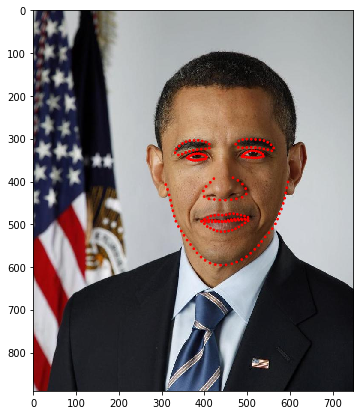

In [8]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1,1,1)
ax.imshow(img)
for k in kpts:
    ax.add_patch(patches.Circle(k, radius=2, color='r'))
plt.show()

## Wrapping the data into `SOLT` format

In [10]:
# Let's first wrap our keypoints into a keypoints container
kpts_wrapped = solt.Keypoints(kpts, img.shape[0], img.shape[1])
# Then, we should wrap the image and the created keypoints into a DataContainer
dc = solt.DataContainer((img, kpts_wrapped), 'IP')

## Defining a simple stream and testing it

In [14]:
stream = solt.Stream([
    slt.Rotate(angle_range=(-20, 20), p=1),
    slt.Crop(512, crop_mode='r')
])
print(stream.to_yaml())

stream:
  interpolation: null
  optimize_stack: false
  padding: null
  transforms:
  - rotate:
      angle_range:
      - -20
      - 20
      ignore_state: true
      interpolation:
      - bilinear
      - inherit
      p: 1
      padding:
      - z
      - inherit
  - crop:
      crop_mode: r



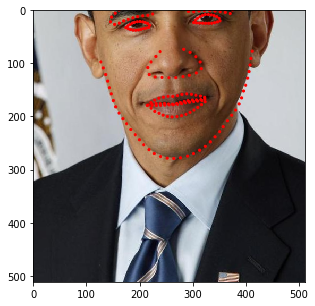

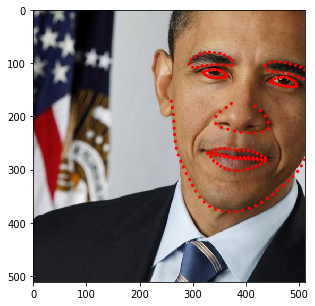

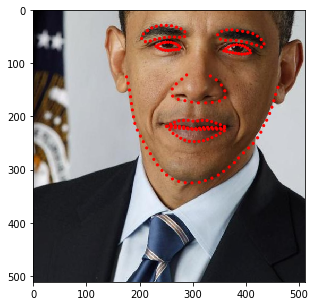

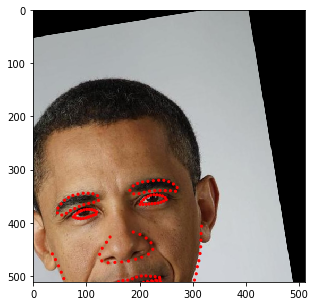

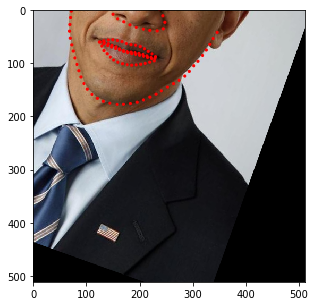

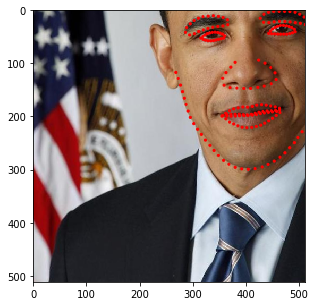

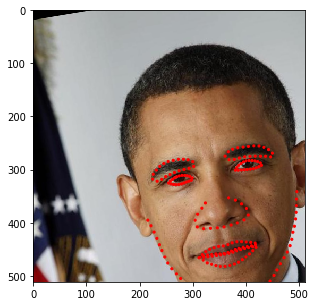

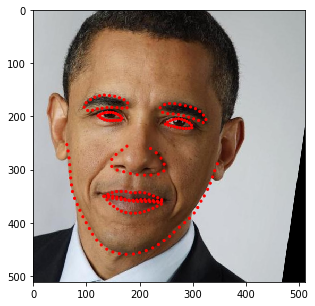

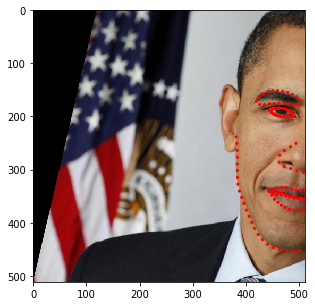

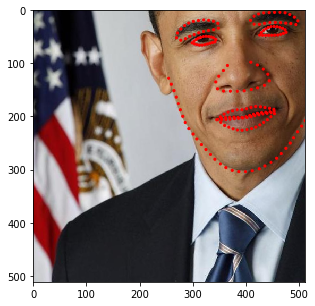

In [15]:
for i in range(10):
    res = stream(dc, return_torch=False)
    img_res, kp_res = res.data
    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(img_res)
    for k in kp_res.data:
        ax.add_patch(patches.Circle(k, radius=2, color='r'))
    plt.show()

You may have noticed that the image size changes depending on the rotation angle. In fact, at this stage, we incorporated such behavior into `SOLT`.
Let's now define a more complicated pipeline.

In [17]:
stream = solt.Stream([
    slt.Projection(
            solt.Stream([
                slt.Scale(range_x=(0.5, 1.3), p=1),
                slt.Rotate(angle_range=(-90, 90), p=1),
                slt.Shear(range_x=(-0.5, 0.5), range_y=None, p=1),
        ]), 
        v_range=(1e-6, 9e-4)),
    slt.GammaCorrection(p=0.5, gamma_range=(0.5, 3)),
    solt.SelectiveStream([
        slt.Blur(p=0.5, blur_type='g', k_size=(11, 21, 31), gaussian_sigma=(1, 10)),
        slt.Blur(p=0.5, blur_type='m', k_size=(11, 21, 31)),
    ]),
    solt.SelectiveStream([
        slt.SaltAndPepper(p=1),
        slt.Noise(p=1)
    ]),
    solt.SelectiveStream([
        slt.Blur(p=0.5, blur_type='g', k_size=(11, 21, 31), gaussian_sigma=(1, 10)),
        slt.Blur(p=0.5, blur_type='m', k_size=(11, 21, 31)),
    ]),
    slt.Pad(600, 'z'),
    slt.Crop(600, crop_mode='c'),
    slt.Crop(512, crop_mode='r')
    
])
print(stream.to_yaml())

stream:
  interpolation: null
  optimize_stack: false
  padding: null
  transforms:
  - projection:
      affine_transforms:
        stream:
          interpolation: null
          optimize_stack: false
          padding: null
          transforms:
          - scale:
              ignore_state: true
              interpolation:
              - bilinear
              - inherit
              p: 1
              range_x:
              - 0.5
              - 1.3
              range_y: null
              same: true
          - rotate:
              angle_range:
              - -90
              - 90
              ignore_state: true
              interpolation:
              - bilinear
              - inherit
              p: 1
              padding:
              - z
              - inherit
          - shear:
              ignore_state: true
              interpolation:
              - bilinear
              - inherit
              p: 1
              padding:
              - z
              -

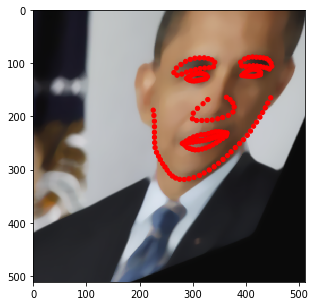

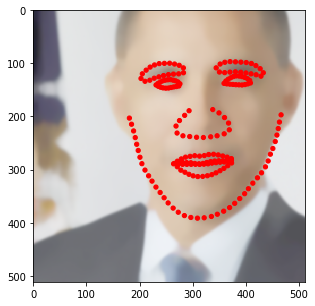

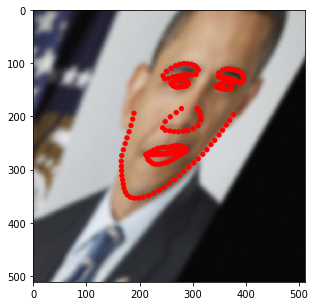

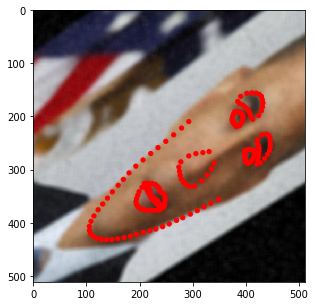

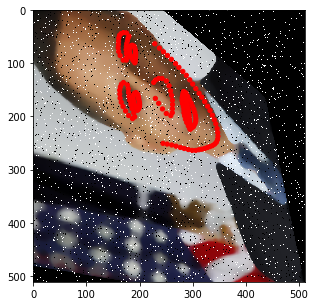

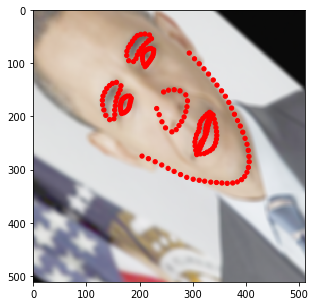

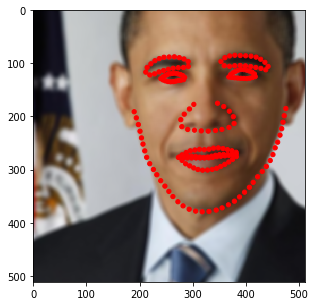

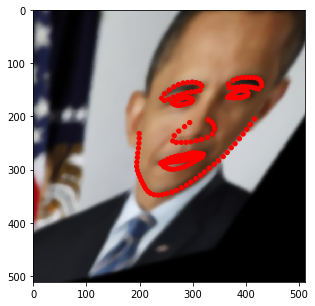

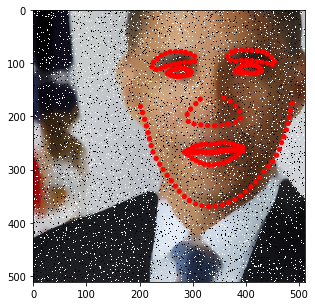

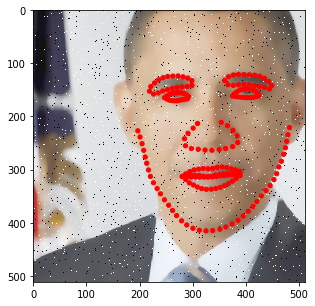

In [18]:
for i in range(10):
    res = stream(dc, return_torch=False)
    img_res, kp_res = res.data
    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(img_res)
    for k in kp_res.data:
        ax.add_patch(patches.Circle(k, radius=4, color='r'))
    plt.show()